# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/datasets/real_estate_data.csv',sep = '\t', decimal = '.')
df.info()
print('\nПервые 5 строчек данных\n\n')
pd.set_option('display.max_columns', None)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

В таблице 23699 строчки, которые состоят из данных, введенными пользователями, и данных, полученными автоматически. Бросается в глаза столбец 'is_apartment', с большим количеством пропусков (возможно это не являлось обязательным полем для заполнения, и пользователи пропускали его. Логичным было бы все пропуски заполнить False). Класс данных, полученных автоматически, имеет больше пропусков. Скорее всего это связано с тем, что программа не обладает стопроцентной точностью в нахождении расстояния и еще меньшей точностью в распознавании прудов и парков. Возможно, если не определено расстояние до центра, то и остальные данные будут пустыми.

### Шаг 2. Предобработка данных

### Удаление пропусков 

Начнем предобработку с потолков

In [2]:
df['ceiling_height'].describe()


count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Замечаем, что min=1, max=100. Это выбросы. Будем заполнять пропущенные значения медианой, так как она наименее чувствительна к выбросам. Пропуски обуславливаются тем, что продавцы, возможно, не знают точную высоту потолка и пропускают эту строку. Выбросы могут быть связаны с неправильным вводом или другими системами единиц.

In [3]:
print('Пропуски в жилой площади до обработки', df['living_area'].isna().sum())
print('Пропуски в высоте потолков до обработки', df['ceiling_height'].isna().sum())
df.loc[df['ceiling_height'].isnull(),'ceiling_height']= df['ceiling_height'].median()
print('Пропуски в высоте потолков после обработки', df['ceiling_height'].isna().sum())
print('Пропуски в жилой площади после обработки', df['living_area'].isna().sum())


Пропуски в жилой площади до обработки 1903
Пропуски в высоте потолков до обработки 9195
Пропуски в высоте потолков после обработки 0
Пропуски в жилой площади после обработки 1903


Жилая прощадь является важным, ценообразующим компонентом, поэтому пустые значения мы просто удалим.

In [4]:

print('Пропуски в жилой площади до обработки', df['living_area'].isna().sum())
df.dropna(subset = ['living_area'], inplace=True)
print('Пропуски в жилой площади после обработки dropna()', df['living_area'].isna().sum())


Пропуски в жилой площади до обработки 1903
Пропуски в жилой площади после обработки dropna() 0


С кухнями поступим аналогичным образом

In [5]:
print('Пропуски в кухонной площади до обработки', df['kitchen_area'].isna().sum())
df.dropna(subset = ['kitchen_area'], inplace = True)
print('Пропуски в кухонной площади после обработки dropna()', df['kitchen_area'].isna().sum())

Пропуски в кухонной площади до обработки 814
Пропуски в кухонной площади после обработки dropna() 0


Заменим пропуски в is_apartment на False,это не является важным фактором, и владелец не вводил эти данные, значит скорее всего это не апартаменты.

In [6]:
df.loc[df['is_apartment'].isna(),'is_apartment'] = False
print('Пропуски is_apartment после обработки', df['is_apartment'].isna().sum())

Пропуски is_apartment после обработки 0


Переходим к балконам. Если стоит пустое значение, то скорее всего балкона нет, поставим просто 0.

In [7]:
df.loc[df['balcony'].isnull(),'balcony'] = 0
print('Пропуски balcony после обработки', df['balcony'].isna().sum())

Пропуски balcony после обработки 0


Перейдем к данным, заполненным автоматически. Посмотрим строки, с пустым значением расстояния до центра

In [8]:
df[df['cityCenters_nearest'].isna()].head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.40,5,False,False,False,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.00,5,False,False,False,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,False,False,False,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
38,10,3150000.0,40.00,2018-03-29T00:00:00,1,2.75,18.0,16.30,9,False,False,False,11.60,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,103.0


Посмотрим, может быть их можно заполнить медианой по городу

In [9]:
print('Значения, которые присутствуют в cityCenters_nearest',df[df['locality_name'] == 'посёлок Мурино']
      ['cityCenters_nearest'].unique(),'\n\n')
sd=df[df['locality_name'] == 'посёлок Мурино'].head()

Значения, которые присутствуют в cityCenters_nearest [nan] 




Очевидный сбой программы, некоторые города просто не получается просчитать, а так как это является важным фактором ценообразования, то придется убрать такие города и сообщить об этом разработчикам.

In [10]:
print('Пропуски в жилой площади до обработки', df['cityCenters_nearest'].isna().sum())
df.dropna(subset = ['cityCenters_nearest'], inplace = True)

print('Пропуски в жилой площади после обработки dropna()', df['cityCenters_nearest'].isna().sum())

Пропуски в жилой площади до обработки 4653
Пропуски в жилой площади после обработки dropna() 0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16329 entries, 0 to 23694
Data columns (total 22 columns):
total_images            16329 non-null int64
last_price              16329 non-null float64
total_area              16329 non-null float64
first_day_exposition    16329 non-null object
rooms                   16329 non-null int64
ceiling_height          16329 non-null float64
floors_total            16293 non-null float64
living_area             16329 non-null float64
floor                   16329 non-null int64
is_apartment            16329 non-null bool
studio                  16329 non-null bool
open_plan               16329 non-null bool
kitchen_area            16329 non-null float64
balcony                 16329 non-null float64
locality_name           16296 non-null object
airports_nearest        16307 non-null float64
cityCenters_nearest     16329 non-null float64
parks_around3000        16329 non-null float64
parks_nearest           7265 non-null float64
ponds_around3000

Удалим строки без названия населенного пункта(благо их всего 30).

In [12]:
df.dropna(subset = ['locality_name'],inplace = True)

Убедимся, что нет дупликатов

In [13]:
print(df.duplicated().sum())

0


### Изменение типов данных

Думаю, остальные данные можно не трогать, займемся изменением типов данных. Хотелось бы перевести большинство float64 в int64 для зрительного удобства. Оставим только total_area,ceiling_height, floors_total, living_area,kitchen_area. 

In [14]:
columns_name=['balcony','last_price','floors_total','days_exposition','ponds_nearest','ponds_around3000',
             'parks_nearest','cityCenters_nearest','airports_nearest']
def func_to_int(data,name):
    data[name] = data.loc[data[name].notna(),name].astype('Int32',errors='ignore')
    return data
for row in columns_name:
    df = func_to_int(df,row)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0
6,6,3700000,37.3,2017-11-02T00:00:00,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0


Nan принадлежит float64, и наличие его в столбце делает его обратно float64, со столбцами без nan все получилось,можно было бы перевести в тип object, но это затруднило бы дальнейший анализ. 

Поменяем тип столбца first_day_exposition в datetime64  и посмотрим общую информацию о данных после обработки.

In [15]:
df['first_day_exposition'] = df['first_day_exposition'].astype('datetime64')

In [16]:
print(df.info())
df_to_end=df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16296 entries, 0 to 23694
Data columns (total 22 columns):
total_images            16296 non-null int64
last_price              16296 non-null Int32
total_area              16296 non-null float64
first_day_exposition    16296 non-null datetime64[ns]
rooms                   16296 non-null int64
ceiling_height          16296 non-null float64
floors_total            16261 non-null Int32
living_area             16296 non-null float64
floor                   16296 non-null int64
is_apartment            16296 non-null bool
studio                  16296 non-null bool
open_plan               16296 non-null bool
kitchen_area            16296 non-null float64
balcony                 16296 non-null Int32
locality_name           16296 non-null object
airports_nearest        16274 non-null Int32
cityCenters_nearest     16296 non-null Int32
parks_around3000        16296 non-null float64
parks_nearest           7251 non-null Int32
ponds_around3000    

Мы подготовили данные для дальнейшего анализа.

### Шаг 3. Посчитайте и добавьте в таблицу

Добавим в таблицу для дальнейшего анализа цену квадратного метра;  
день недели, месяц и год публикации объявления;  
этаж квартиры. варианты — первый, последний, другой;    
соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [17]:
df['price_per_meter'] = df['last_price'] / df['total_area']
df['day_of_week'] = pd.DatetimeIndex(df['first_day_exposition']).day
df['day_of_week_name'] = df['first_day_exposition'].dt.weekday_name
df['month'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year'] = pd.DatetimeIndex(df['first_day_exposition']).year
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN,120370.370370,7,Thursday,3,2019
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0,92785.714286,20,Thursday,8,2015
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017


Напишем функцию для определения этажа квартиры.

In [18]:
def find_floor(line):
    total_floors = line['floors_total']
    floor = line['floor']
    if floor == total_floors:
        return 'Последний'
    elif floor == 1:
        return 'Первый'
    else:
        return 'Другой'
df['floor_type'] = df.apply(find_floor,axis=1)
df['floor_type'].unique()

array(['Другой', 'Первый', 'Последний'], dtype=object)

Добавим последние два столбца, которые будут описывать соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [19]:
df['living_to_total'] = df['living_area'] / df['total_area']
df['kitchen_to_total'] = df['kitchen_area'] / df['total_area']
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN,120370.370370,7,Thursday,3,2019,Другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0,92785.714286,20,Thursday,8,2015,Другой,0.612500,0.148214
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017,Другой,0.284182,0.386059


Мы подготовили нашу таблицу для проведения исследования.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучим некоторые параметры таблицы и построим для них гистограммы. Начнем с площади

1 ) Площадь
count    16296.000000
mean        63.249419
std         37.394810
min         14.000000
25%         41.700000
50%         54.345000
75%         73.000000
max        900.000000
Name: total_area, dtype: float64


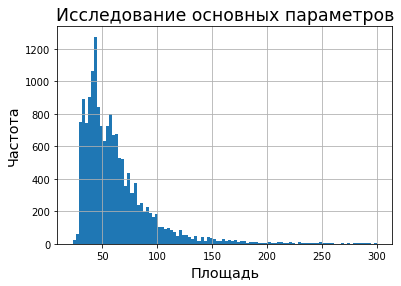

2 ) Цена
count    1.629600e+04
mean     7.457845e+06
std      1.058084e+07
min      1.219000e+04
25%      4.004500e+06
50%      5.250000e+06
75%      7.600000e+06
max      4.200000e+08
Name: last_price, dtype: float64


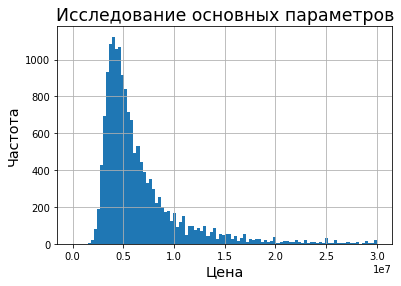

3 ) Комнаты
count    16296.000000
mean         2.157892
std          1.109051
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


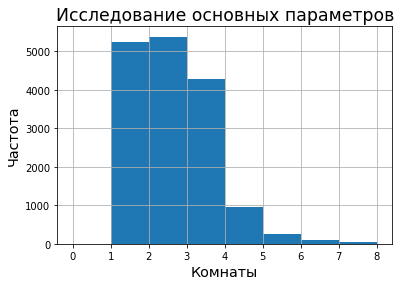

4 ) Высота потолков
count    16296.000000
mean         2.735217
std          1.003572
min          1.000000
25%          2.600000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64


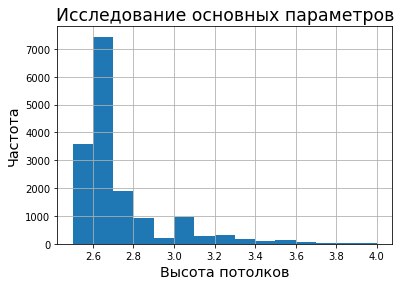

In [20]:
df_names=['total_area','last_price','rooms','ceiling_height']
df_bins=[100,100,8,15]
df_ranges=[(23,300),(0,30*10**6),(0,8),(2.5,4)]
df_xlabel=['Площадь','Цена','Комнаты','Высота потолков']
i=0
for row in df_names:
    print(i+1,')',df_xlabel[i])
    total_area_df=df[row].hist(bins=df_bins[i],range=df_ranges[i]);
    print(df[row].describe())
    plt.xlabel(df_xlabel[i],fontsize='x-large')
    plt.ylabel("Частота",fontsize='x-large')
    plt.title("Исследование основных параметров",fontsize='xx-large')
    plt.show()
    i+=1



1) 14 является слишком маленьким значением для квартиры, возможно продавцы ошиблись. 900, напротив, слишком большое(хотя оказывается такие квартиры есть, удалять их не будем). Эти выбросы нам предстоит обработать позже, будем помнить о них.Гистограмма напоминает Пуассоновское распределение. Мы видим что основное количество объявлений находится в районе 50 кв. метров. Продолжим изучать данные, посмотрим распределение цены.  
2) 12 тыс за квартиру? Выглядит выгодно, но не реалистично, разберемся с этим позже, а сейчас построим гистограмму. Видим, что основная масса цен находятся до 10 миллионов. Посмотрим гистограмму. Действительно, основная масса цен находится в районе 4 миллионов рублей  
3) Наибольшее значение выглядит странно, остановимся на 8 комнатах. В основном комнат меньше 4.  
4) Потолки в 1 метр и 100 являюся явными опечатками, не будем учитывать их в гистограмме. Основная высота потолков около 2.6 метров, но есть и большие значения, которые мы будем учитывать  

<a href="#bottom">Ссылка вниз, к выводу</a>

### Изучение времени продажи квартир

Для начала рассчитаем среднее и медиану

In [21]:
print('Среднее время продажи:', df['days_exposition'].mean())
print('Медиана времени продажи', df['days_exposition'].median())

Среднее время продажи: 185.40382174587506
Медиана времени продажи 100.0


Видим, что среднее почти в два раза больше медианы, чувствуется влияние особенно долгих объявлений. Посмотрим общую информацию

In [22]:
df['days_exposition'].describe()

count    14182.000000
mean       185.403822
std        224.886273
min          1.000000
25%         42.000000
50%        100.000000
75%        238.000000
max       1572.000000
Name: days_exposition, dtype: float64

Q1 равно  42 дням, достаточно быстрая продажа для недвижимости. Q3 равно 8 месяцам. Построим гистограмму и диаграмму размаха

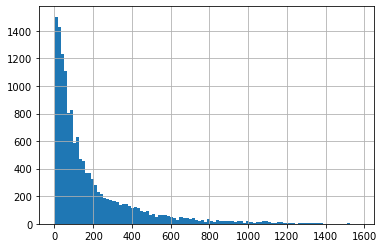

(0, 600)

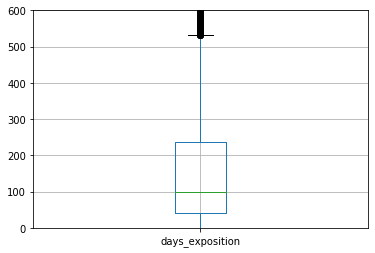

In [23]:
df['days_exposition'].hist(bins=100)
plt.show()
df.boxplot(column='days_exposition')
plt.ylim(0,600)

Будем считать, что продажа прошла _очень быстро_ , если она меньше 40 дней. Если же она длилась больше 550 дней, то это _необычно долго_. Возможно, хозяева поставили слишком высокую цену, либо указали что-то неправильно. Создадим новую таблицу без выбросов, вспомнив все странные значения, полученные до этого.


In [24]:
df_new=df.query('days_exposition<550 and ceiling_height>2.5 and ceiling_height<4 and rooms<10\
and last_price>500000 and total_area>17')
df_new.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017,Другой,0.284182,0.386059
10,5,5050000,39.6,2017-11-16,1,2.67,12,20.3,3,False,False,False,8.5,0,Санкт-Петербург,38357,13878,1.0,310,2,553,137.0,127525.252525,16,Thursday,11,2017,Другой,0.512626,0.214646
11,9,3300000,44.0,2018-08-27,2,2.65,5,31.0,4,False,False,False,6.0,1,Ломоносов,48252,51677,0.0,NaN,0,NaN,7.0,75000.000000,27,Monday,8,2018,Другой,0.704545,0.136364


Построим графики зависимости цены от площади квартиры, количества комнат, удаленности от центра и рассчитаем коэф. корреляции.<a name="1"></a>

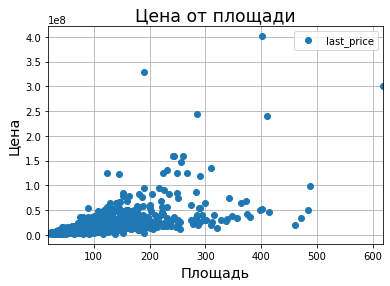

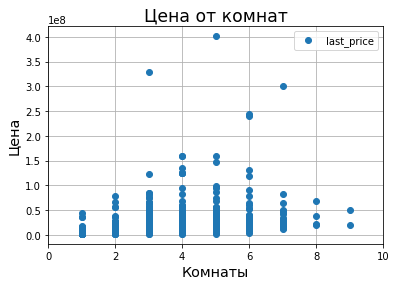

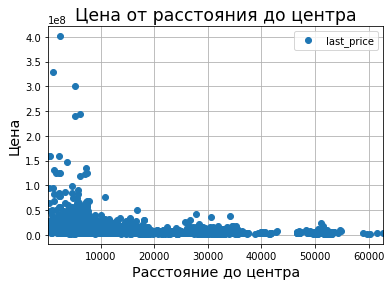

In [25]:
df_new_names=['total_area','rooms','cityCenters_nearest']
df_new_titles=['Цена от площади','Цена от комнат','Цена от расстояния до центра']
df_new_xlabel=["Площадь","Комнаты","Расстояние до центра"]
df_new_end=[]
i=0
for row in df_new_names:   
    k=df_new.plot(x = row, y = 'last_price',style='o',grid=True)
    if row=='rooms':
        plt.xlim(0,10)
    plt.xlabel(df_new_xlabel[i],fontsize='x-large')
    plt.ylabel('Цена',fontsize='x-large')
    plt.title(df_new_titles[i],fontsize='xx-large')
    df_new_end.append(k)
    plt.show()
    i+=1


In [26]:
df_for_corr=df_new.loc[:,['last_price','total_area','rooms','cityCenters_nearest']]
df_for_corr.corr()

,last_price,total_area,rooms,cityCenters_nearest
last_price,1.000000,0.658206,0.386801,-0.220050
total_area,0.658206,1.000000,0.778553,-0.224388
rooms,0.386801,0.778553,1.000000,-0.196932
cityCenters_nearest,-0.220050,-0.224388,-0.196932,1.000000


Видим, что цена сильно зависит от площади квартиры(положительный коэф. корреляции), меньше зависит от числа комнат(аналогично). От удаленности от центра зависит не так сильно, но при увеличении расстояния цена уменьшается.  
Рассмотрим теперь зависимость от этажа. Рассчитаем медиану для каждого и построим график.

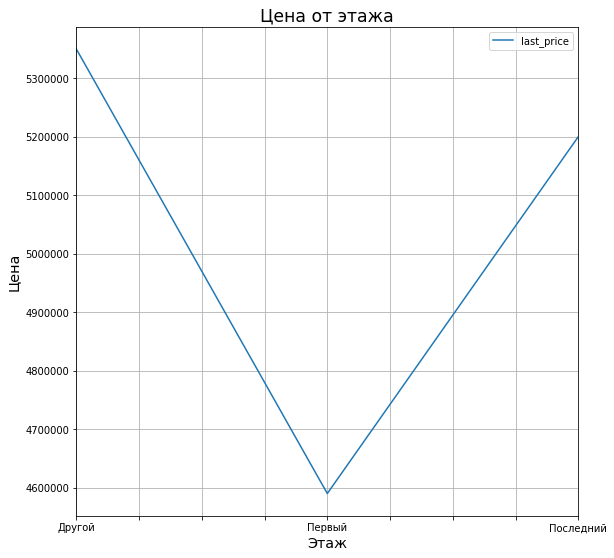

In [27]:
df_floor=df_new.pivot_table(index= 'floor_type', values = 'last_price', aggfunc = 'median')
df_floor.plot(grid = True, figsize = (9,9));
plt.title('Цена от этажа',fontsize='xx-large')
plt.xlabel('Этаж',fontsize='x-large')
plt.ylabel('Цена',fontsize='x-large')
plt.show()

Видим, что на первом этаже квартиры стоят дешевле, почти на 1млн, чем на "Других" этажах.<a name="2"></a>

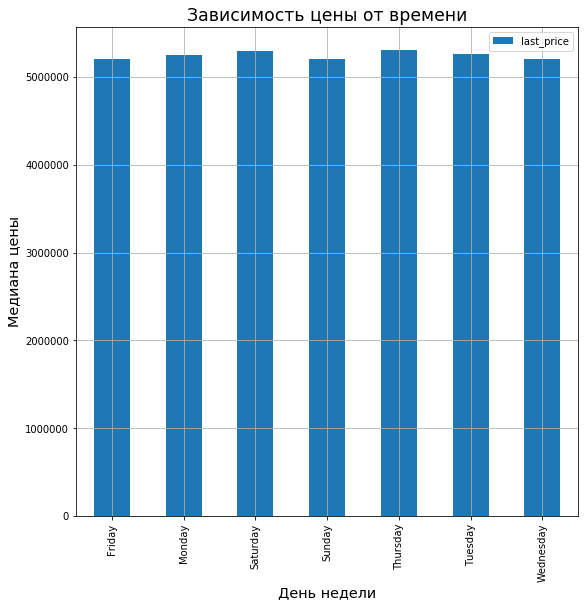

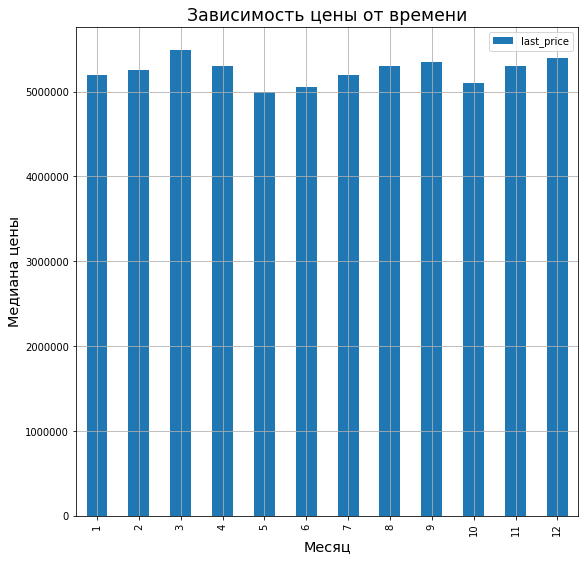

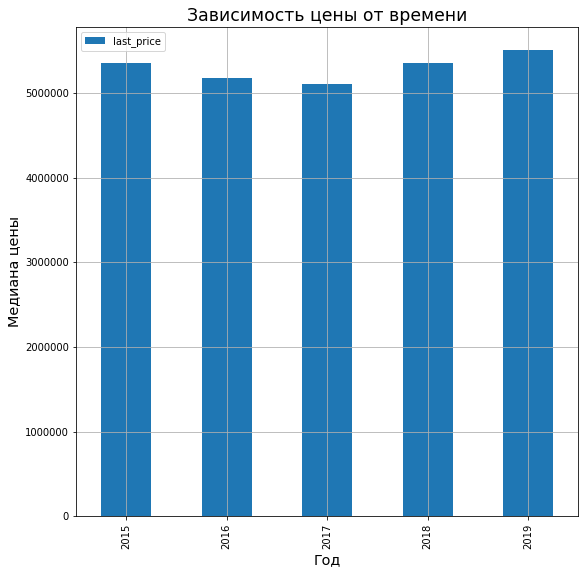

In [28]:
df_new_columns=['day_of_week_name','month','year']
df_new_date_analysis=[]
xlabels=['День недели','Месяц','Год']
i=0
for row in df_new_columns:
    df_new_cycle= df_new.pivot_table(index = row, values = 'last_price', aggfunc = 'median')
    k=df_new_cycle.plot(kind = 'bar', grid = True, figsize = (9,9));
    plt.xlabel(xlabels[i],fontsize='x-large')
    plt.ylabel('Медиана цены',fontsize='x-large')
    plt.title('Зависимость цены от времени',fontsize='xx-large')
    df_new_date_analysis.append(k)
    i+=1

Из этих графиков делаем выводы:  
1) Как мы можем видеть, цена не зависит от дня, когда вывешивается объявление о продаже.  
2) Можем заметить только разницу между мартом и маем, но и она не очень сильная. Будем считать, что и месяц не влияет  
3) Видим, что в последние два года наблюдается рост. Делаем вывод, что цена зависит от года(от экономической ситуации в стране).

<a href="#bottom">Ссылка вниз, к выводу</a>

### Наиболее популярные населенные пункты

In [29]:
top_ten=df_new.groupby('locality_name').count().sort_values('last_price' , ascending = False).head(10).index
top_ten_data = (df_new.loc[df_new['locality_name'].isin(top_ten)])
print('Наибольшее количество объявлений', top_ten)

Наибольшее количество объявлений Index(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Парголово', 'Пушкин',
       'Колпино', 'Петергоф', 'Сестрорецк', 'Красное Село', 'Ломоносов',
       'Кронштадт'],
      dtype='object', name='locality_name')


In [30]:
top_ten_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017,Другой,0.284182,0.386059
10,5,5050000,39.6,2017-11-16,1,2.67,12,20.3,3,False,False,False,8.5,0,Санкт-Петербург,38357,13878,1.0,310,2,553,137.0,127525.252525,16,Thursday,11,2017,Другой,0.512626,0.214646
11,9,3300000,44.0,2018-08-27,2,2.65,5,31.0,4,False,False,False,6.0,1,Ломоносов,48252,51677,0.0,NaN,0,NaN,7.0,75000.000000,27,Monday,8,2018,Другой,0.704545,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23688,19,9200000,101.0,2019-04-01,3,3.05,15,63.0,12,False,False,False,15.0,0,Санкт-Петербург,15632,14428,0.0,NaN,0,NaN,23.0,91089.108911,1,Monday,4,2019,Другой,0.623762,0.148515
23689,13,3550000,35.3,2018-02-28,1,2.86,15,16.3,4,False,False,False,9.1,2,Санкт-Петербург,17284,16081,1.0,353,2,652,29.0,100566.572238,28,Wednesday,2,2018,Другой,0.461756,0.257790
23690,3,5500000,52.0,2018-07-19,2,2.65,5,31.0,2,False,False,False,6.0,0,Санкт-Петербург,20151,6263,1.0,300,0,NaN,15.0,105769.230769,19,Thursday,7,2018,Другой,0.596154,0.115385
23691,11,9470000,72.9,2016-10-13,2,2.75,25,40.3,7,False,False,False,10.6,1,Санкт-Петербург,19424,4489,0.0,NaN,1,806,519.0,129903.978052,13,Thursday,10,2016,Другой,0.552812,0.145405


Посчитаем среднюю цену квадратного метра в этих населённых пунктах.

In [31]:
top_ten_end=top_ten_data.pivot_table(index = 'locality_name',values = 'price_per_meter', aggfunc = 'mean').sort_values('price_per_meter'
                                                                                                           ,ascending = False)
top_ten_end

,price_per_meter
locality_name,
Санкт-Петербург,112507.802165
Пушкин,103474.946140
Сестрорецк,102022.586360
посёлок Парголово,89911.995183
Петергоф,83388.274773
Кронштадт,79984.108908
посёлок Шушары,77570.875055
Колпино,74699.263657
Красное Село,72176.181397


Самой дорогой оказалась недвижимость в Санкт-Петербург, дальше идут Пушкин с Сестрорецком. Самая дешевая недвижимость в Красном Селе и Ломоносове

### Определение границы центральной области

Создаем столбец с расстоянием до центра в километрах: округлим до целых значений.

In [32]:
pd.options.mode.chained_assignment = None
df_new['cityCenters_nearest_round'] = (df_new['cityCenters_nearest'] / 1000).round(0)
df_new['cityCenters_nearest_round'] =  df_new['cityCenters_nearest_round'].astype('int')

Text(0, 0.5, 'Средняя цена')

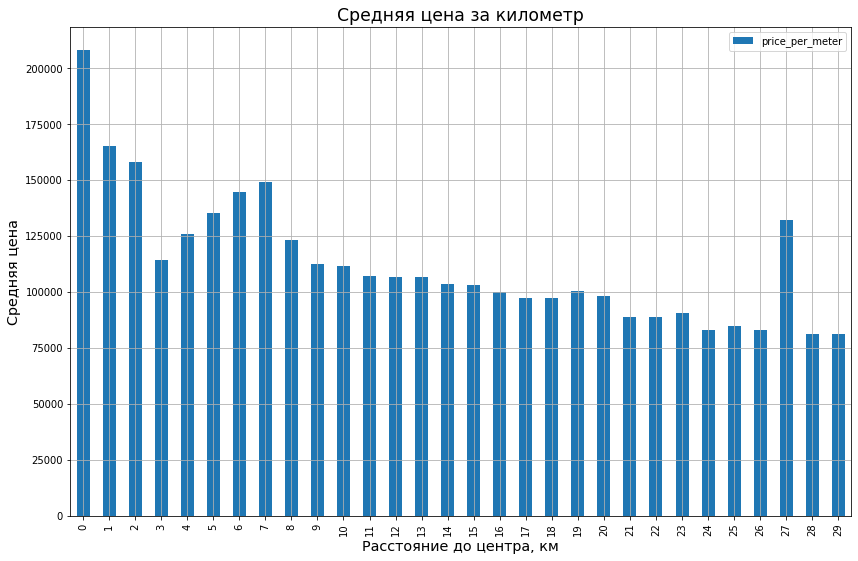

In [33]:
price_per_km = df_new.query('locality_name=="Санкт-Петербург"').pivot_table(index = 'cityCenters_nearest_round',
                                                                            values = 'price_per_meter',aggfunc = 'mean')
price_per_km_graphic=price_per_km.plot(kind = 'bar',figsize = (14 , 9),grid=True,legend=True);
plt.title('Средняя цена за километр',fontsize='xx-large')
plt.xlabel('Расстояние до центра, км',fontsize='x-large')
plt.ylabel('Средняя цена',fontsize='x-large')

Наблюдается резкое падение цен у трех км, дальше снова идет повышение(что-то странное находится на 3 км, но для центра как-то мало). Будем считать радиус центральной зоны 9 км. Выделим таблицу с объявлениями в центре.

In [34]:
city_center_data = df_new.query('cityCenters_nearest_round < 9')

### Анализ квартир в центре

<a name="3"></a>

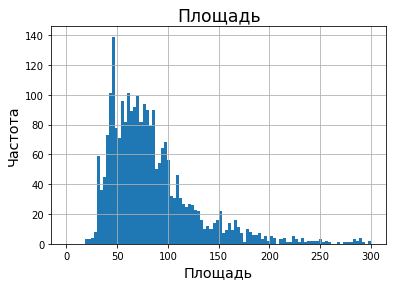

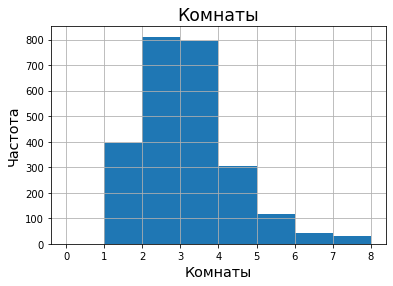

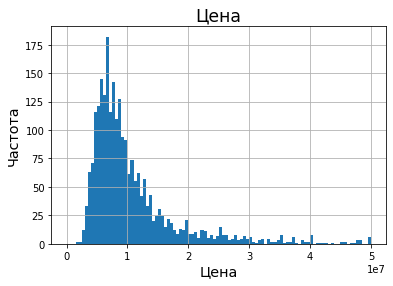

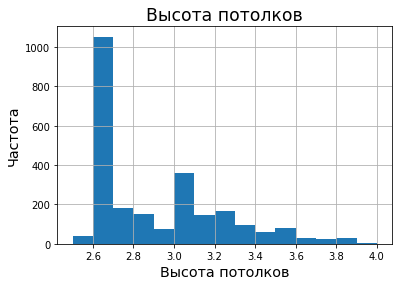

In [35]:
city_center_data_bins=[100,8,100,15]
city_center_data_bins_titles=['Площадь','Комнаты','Цена','Высота потолков']
city_center_data_bins_ranges=[(0,300),(0,8),(0,5*10**7),(2.5,4)]
city_center_columns=['total_area','rooms','last_price','ceiling_height']
city_center_data_main=[]
i=0
for row in city_center_columns:
    l=city_center_data[row].plot(kind = 'hist',
                               bins = city_center_data_bins[i],
                               grid = True, range = city_center_data_bins_ranges[i])
    city_center_data_main.append(l)
    plt.title(city_center_data_bins_titles[i],fontsize='xx-large')
    plt.xlabel(city_center_data_bins_titles[i],fontsize='x-large')
    plt.ylabel('Частота',fontsize='x-large')
    plt.show()
    i+=1


Смотря на эти графики можно сделать следующие выводы:  
1) Квартир прощадью до 50 м. кв намного меньше в центре, преобладает диапазон от 50 до 100 м.кв.  
2) Квартиры дороже. Обычные стоят в среднем около 4 млн, а в центре около 6 млн.  
3) В центре меньше однушек, преобладают двушки и трешки  
4) Распределение высоты потолков одинаковое(но высотой 3м выделяются теперь заметнее).

<a href="#bottom">Ссылка вниз, к выводу</a>

<a name="4"></a>

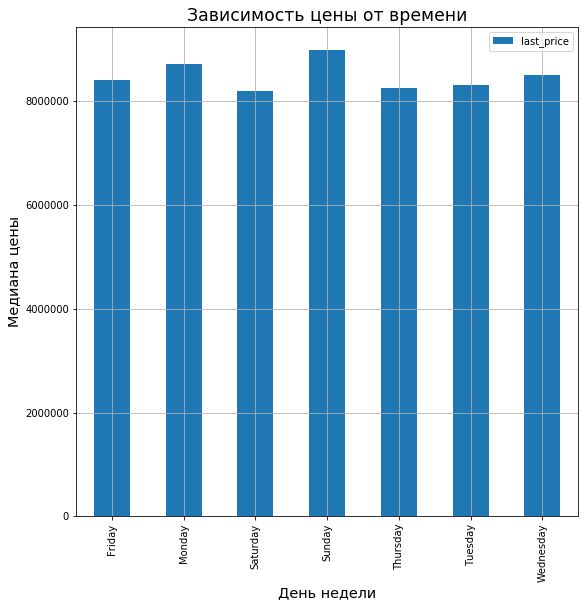

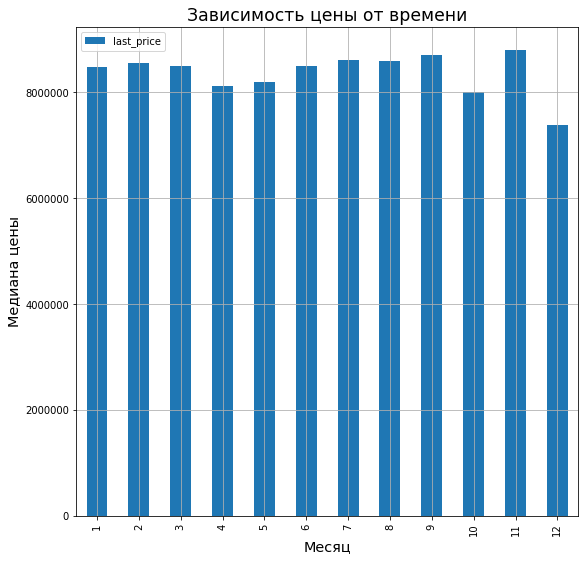

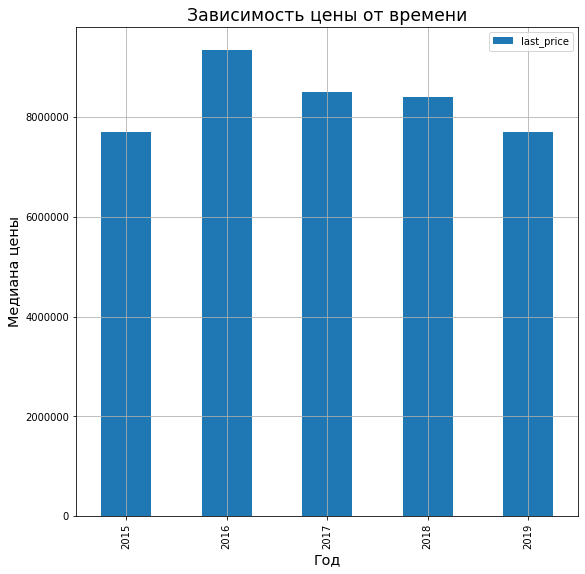

In [36]:
city_center_columns=['day_of_week_name','month','year']
city_center_date_analysis=[]
xlabels=['День недели','Месяц','Год']
i=0
for row in city_center_columns:
    city_center_data_cycle= city_center_data.pivot_table(index = row, values = 'last_price', aggfunc = 'median')
    k=city_center_data_cycle.plot(kind = 'bar', grid = True, figsize = (9,9));
    #plt.ylim(0,10000000)
    plt.xlabel(xlabels[i],fontsize='x-large')
    plt.ylabel('Медиана цены',fontsize='x-large')
    plt.title('Зависимость цены от времени',fontsize='xx-large')
    city_center_date_analysis.append(k)
    i+=1


Сильного различия в днях и месяцах не замечается(кроме декабря и ноября, но это не играет большой роли). Разница в годах координально отличается. Цена на недвижимость с годами падает, а 2016 год был самый выгодный.


<a href="#bottom">Ссылка вниз, к выводу</a>

In [37]:
city_center_data_corr = city_center_data.loc[:,['last_price','total_area','rooms','cityCenters_nearest','ceiling_height']]
city_center_data_corr.corr()

,last_price,total_area,rooms,cityCenters_nearest,ceiling_height
last_price,1.000000,0.650969,0.349901,-0.092931,0.134323
total_area,0.650969,1.000000,0.768484,-0.156295,0.241574
rooms,0.349901,0.768484,1.000000,-0.215563,0.244651
cityCenters_nearest,-0.092931,-0.156295,-0.215563,1.000000,-0.230732
ceiling_height,0.134323,0.241574,0.244651,-0.230732,1.000000


Тут влияние удаленности от центра можно уже не учитывать. В остальном основные параметры ценообразования остаются те же.

### Шаг 5. Общий вывод

При первоначальной обработке данных (удаление и замена пропусков) нашли проблему в программе, определяющую расстояние до центра и остальные географические параметры. 

In [38]:
sd.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.43,26,False,False,False,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
38,10,3150000.0,40.00,2018-03-29T00:00:00,1,2.75,18.0,16.30,9,False,False,False,11.60,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,103.0
192,14,3270000.0,39.40,2017-04-17T00:00:00,1,2.65,24.0,19.20,9,False,False,False,11.00,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,79.0
281,3,3600000.0,45.20,2018-11-24T00:00:00,1,2.72,18.0,18.00,12,False,False,False,14.20,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,52.0
405,20,6650000.0,65.00,2018-08-15T00:00:00,2,2.75,25.0,35.00,5,False,False,False,13.00,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,242.0


В некоторых столбцах заполнили пропущенные данные(balcony=0, is_apartment=False). Отфильтровав таблицу, мы поменяли тип данных в некоторых столбцах. В следующем шаге добавили день недели, месяц, год, тип этажа, отношение жилой и кухонной площади к общей. Получили такую таблицу:

In [39]:
df_to_end.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day_of_week,day_of_week_name,month,year,floor_type,living_to_total,kitchen_to_total
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863,16028,1.0,482,2,755,NaN,120370.370370,7,Thursday,3,2019,Другой,0.472222,0.231481
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,посёлок Шушары,12817,18603,0.0,NaN,0,NaN,81.0,82920.792079,4,Tuesday,12,2018,Первый,0.460396,0.272277
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741,13933,1.0,90,2,574,558.0,92785.714286,20,Thursday,8,2015,Другой,0.612500,0.148214
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856,8098,2.0,112,1,48,121.0,100000.000000,19,Tuesday,6,2018,Другой,0.320000,0.410000
6,6,3700000,37.3,2017-11-02,1,2.65,26,10.6,6,False,False,False,14.4,1,посёлок Парголово,52996,19143,0.0,NaN,0,NaN,155.0,99195.710456,2,Thursday,11,2017,Другой,0.284182,0.386059


Изучили зависимость цены от основных параметров и выяснили, что цена больше зависит от общей площади, чем от удаленности от центра

<a href="#1">К основным параметрам</a>
<a name="bottom"></a>

Мы выяснили, что цена не зависит ото дня, в который она была выложена, так же как и от месяца(я думаю различие имеет только случайный характер, серьезных выводов на этом делать не стоит) Однако цена зависит от года, и в последние два года она начинает рости.  
<a href="#2">К графикам по датам</a>  
Мы получили 10 самый популярных мест по продажам и отсортировали их по цене за квадратный метр

In [40]:
top_ten_end

,price_per_meter
locality_name,
Санкт-Петербург,112507.802165
Пушкин,103474.946140
Сестрорецк,102022.586360
посёлок Парголово,89911.995183
Петергоф,83388.274773
Кронштадт,79984.108908
посёлок Шушары,77570.875055
Колпино,74699.263657
Красное Село,72176.181397


Мы выявили сегмент квартир в центре и провели аналогичный анализ. Выяснили, что, конечно, квартиры в центре дороже, однако наблюдается тенденция роста цен недвижимости в пределах центра. А цены на недвижимость в центре начинают падать  
<a href="#3">К графикам зависимости цены в центре</a>  
<a href="#4">К графикам по датам в центре</a>